### Import Libraries

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import mne
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from mnn_torch.devices import load_SiOx_multistate
from mnn_torch.models import MSNN, MCSNN
from snntorch import surrogate
from mnn_torch.effects import compute_PooleFrenkel_parameters
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import umap.umap_ as umap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path



In [2]:
# test cuda availability
x = torch.rand(5, 3)
print(x)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

tensor([[0.1007, 0.5593, 0.1227],
        [0.2058, 0.9236, 0.6750],
        [0.1832, 0.5893, 0.3974],
        [0.3826, 0.6274, 0.4803],
        [0.6204, 0.3129, 0.5691]])


'NVIDIA GeForce RTX 4090'

### Load EEG Data and Initialize Parameters

In [3]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file C:\Users\User\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


c:\Users\User\anaconda3\envs\mnn_torch\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


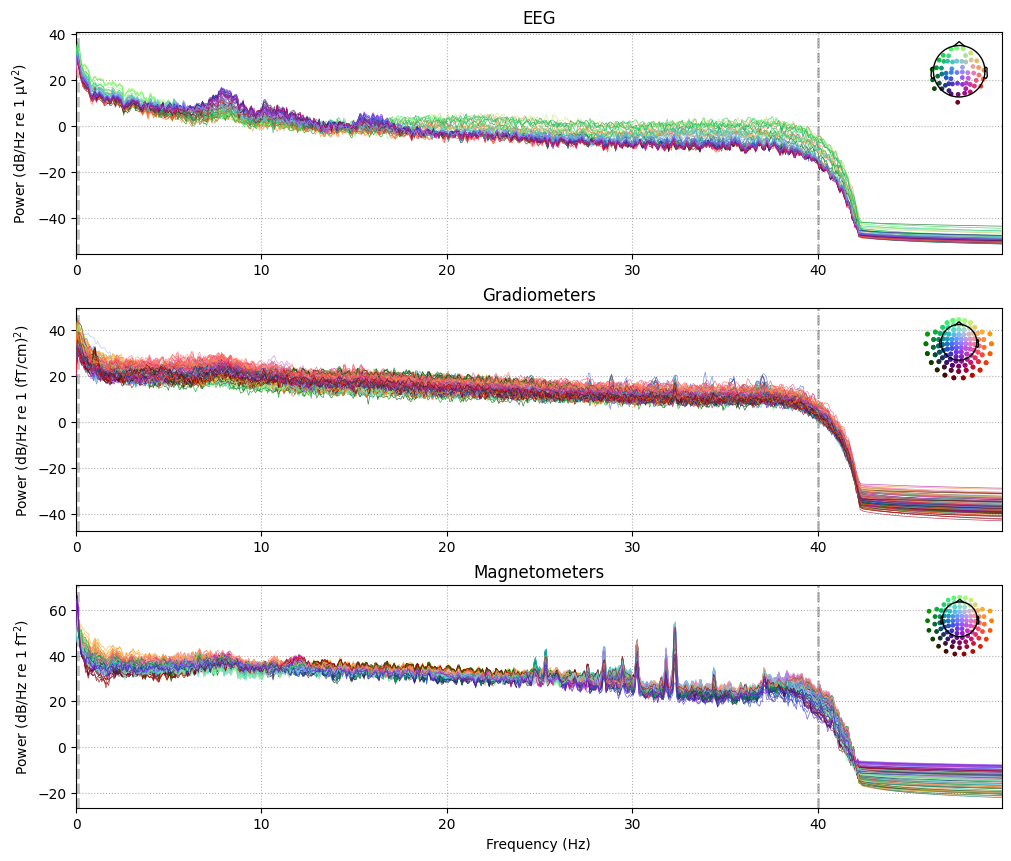

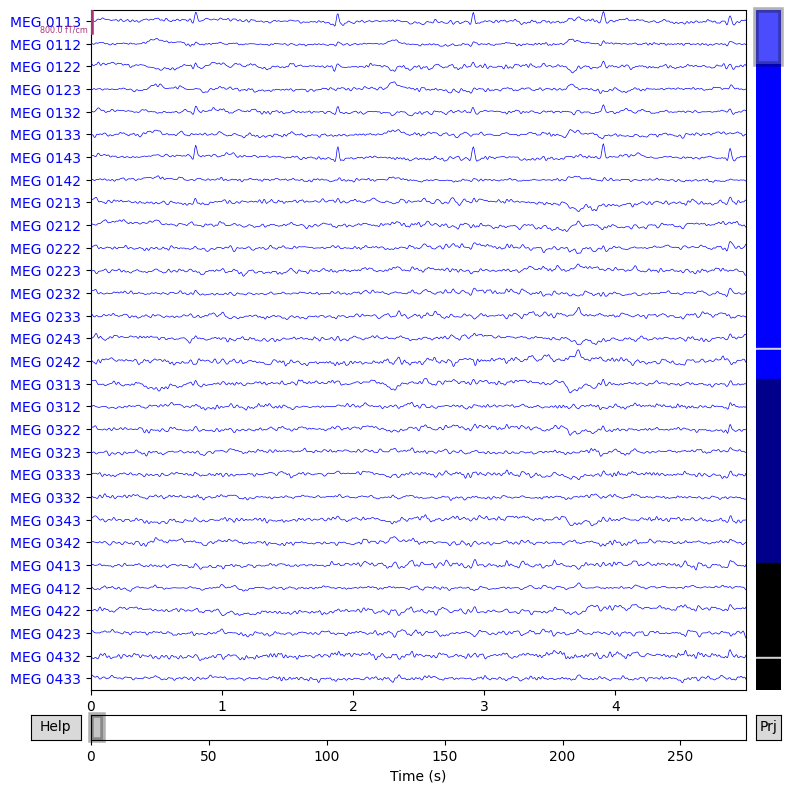

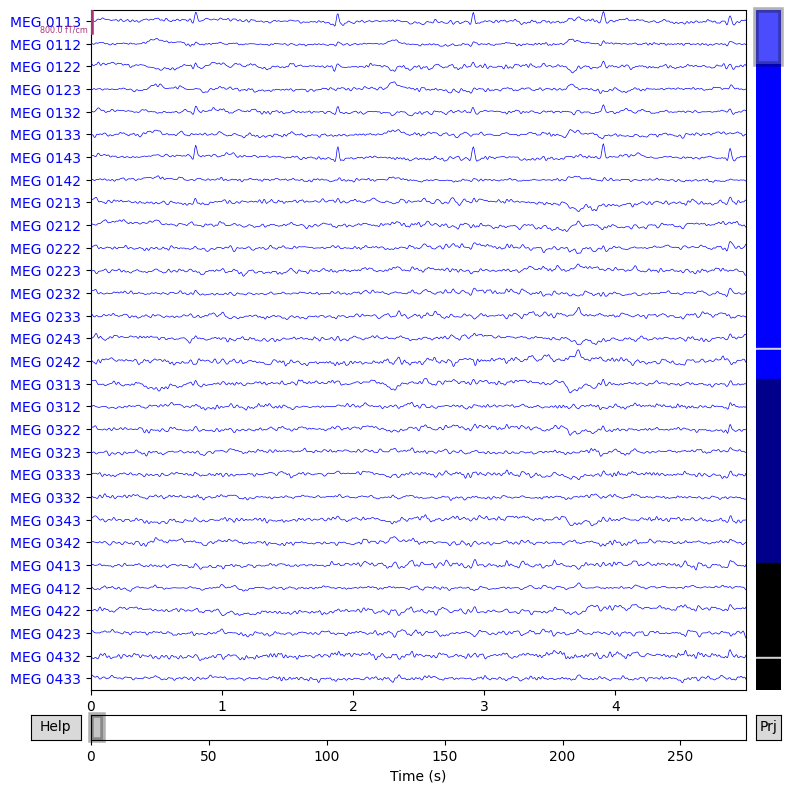

In [4]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=30)

Fitting ICA to data using 364 channels (please be patient, this may take a while)


Selecting by number: 20 components
Fitting ICA took 1.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


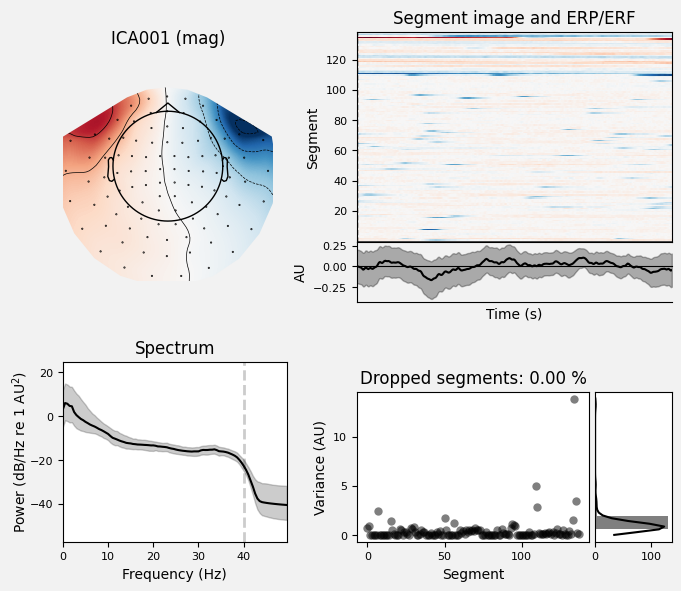

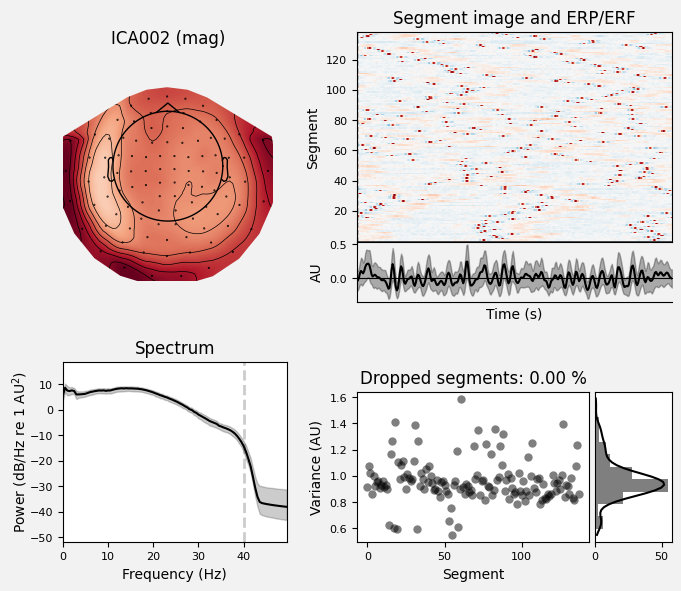

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [5]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


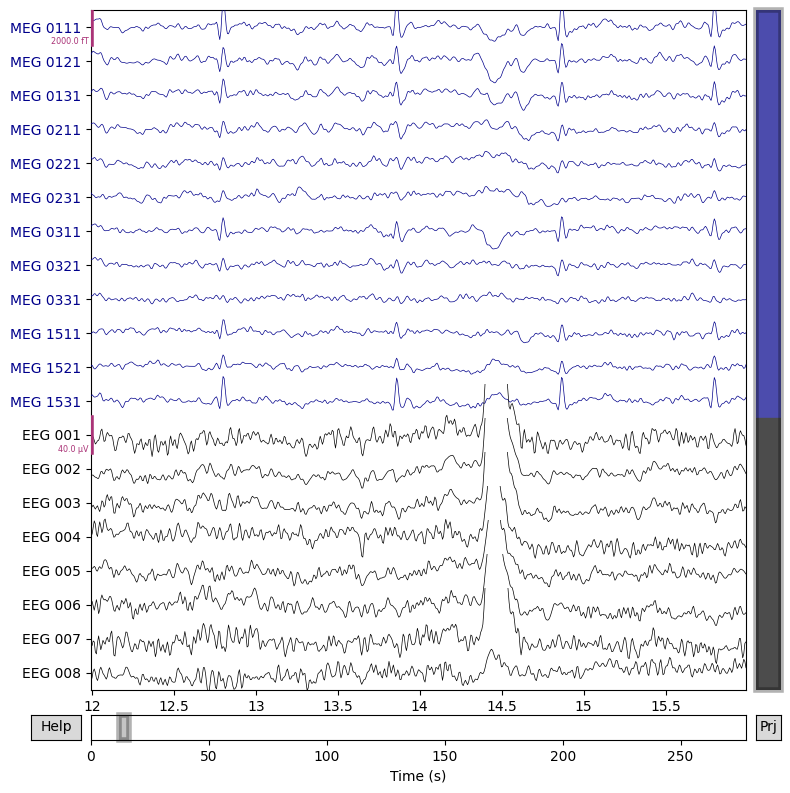

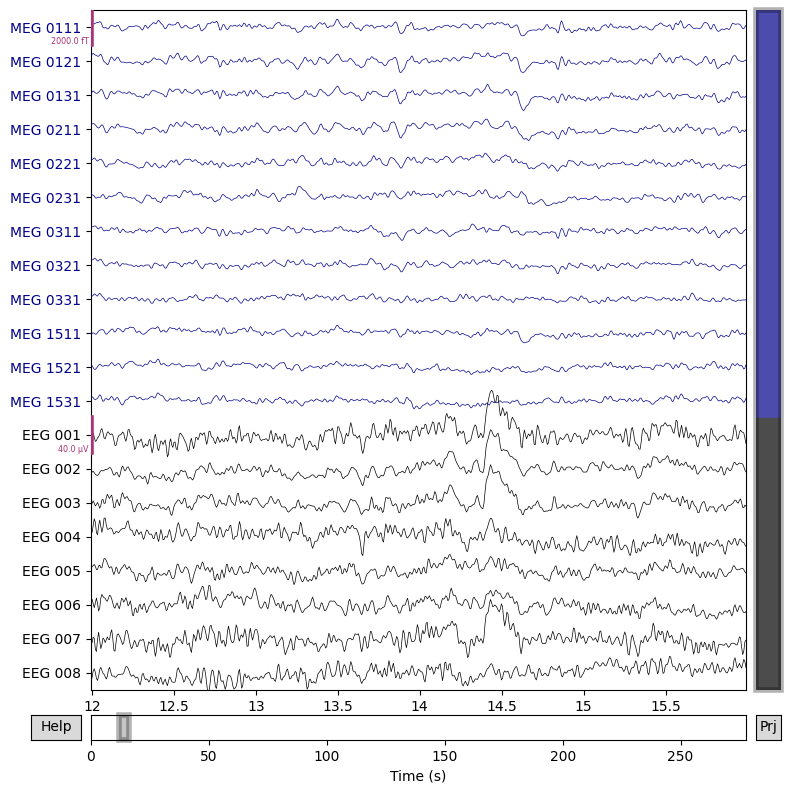

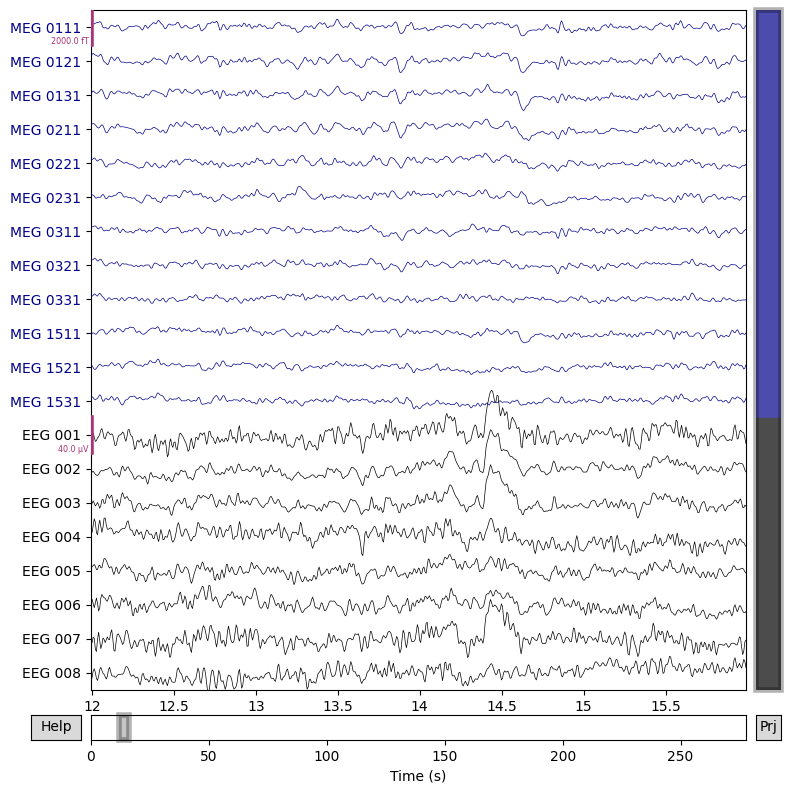

In [6]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)
chs = [
    "MEG 0111",
    "MEG 0121",
    "MEG 0131",
    "MEG 0211",
    "MEG 0221",
    "MEG 0231",
    "MEG 0311",
    "MEG 0321",
    "MEG 0331",
    "MEG 1511",
    "MEG 1521",
    "MEG 1531",
    "EEG 001",
    "EEG 002",
    "EEG 003",
    "EEG 004",
    "EEG 005",
    "EEG 006",
    "EEG 007",
    "EEG 008",
]
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4)

Finding events on: STI 014
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


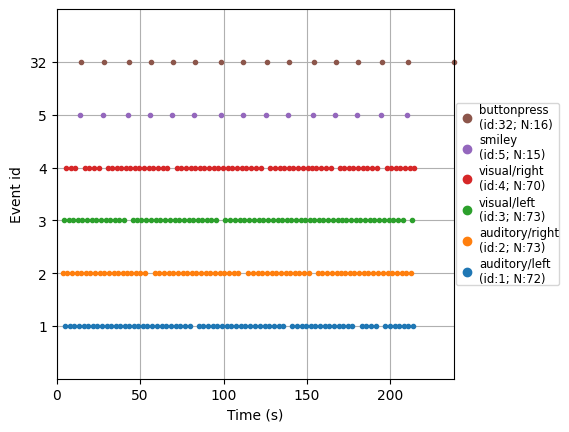

In [7]:
events = mne.find_events(raw, stim_channel="STI 014")
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

In [8]:
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


In [9]:
conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]
del raw, epochs  # free up memory



Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


Multiple channel types selected, returning one figure per type.
combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


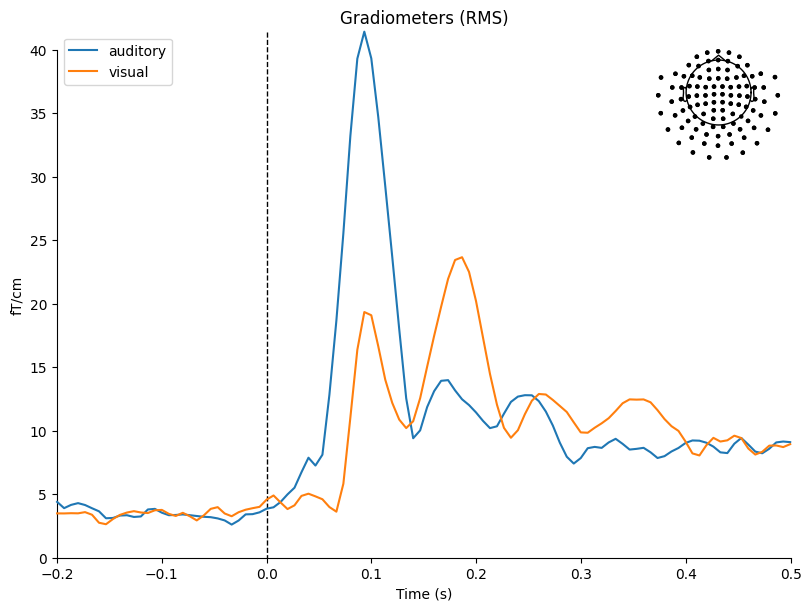

combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


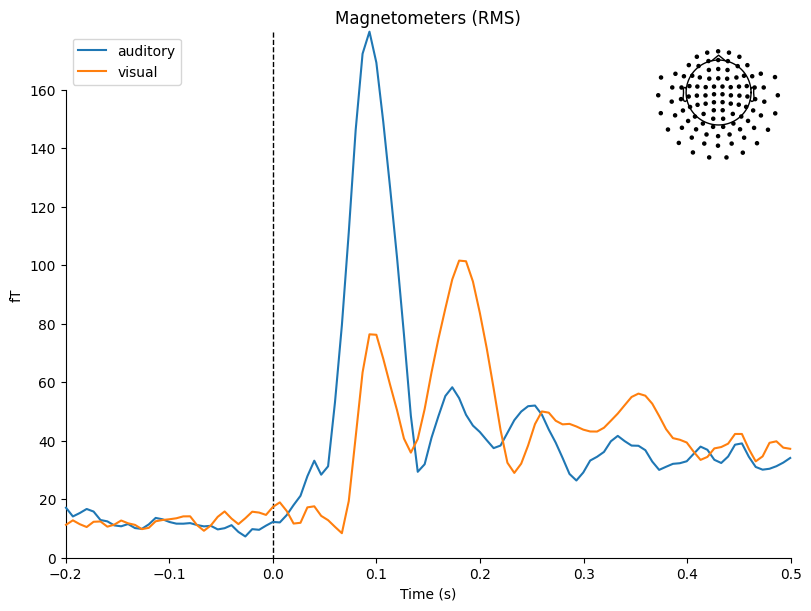

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


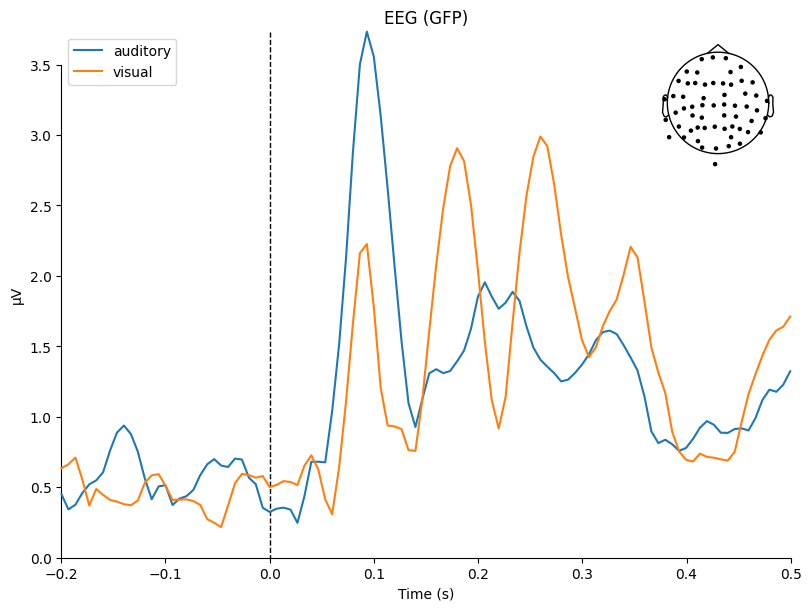

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [10]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(auditory=aud_evoked, visual=vis_evoked),
    legend="upper left",
    show_sensors="upper right",
)

Projections have already been applied. Setting proj attribute to True.


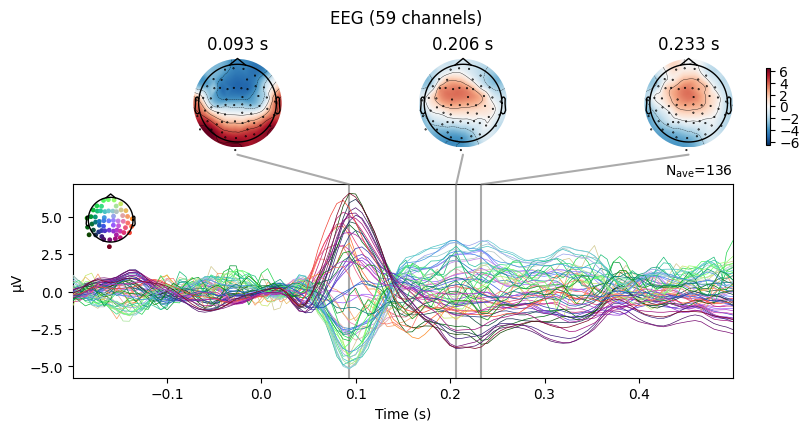

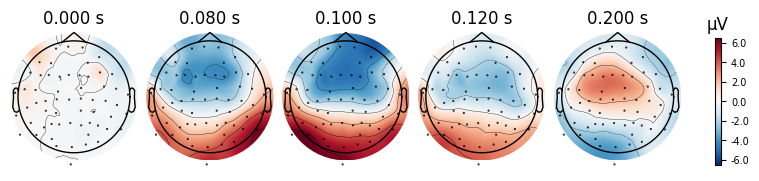

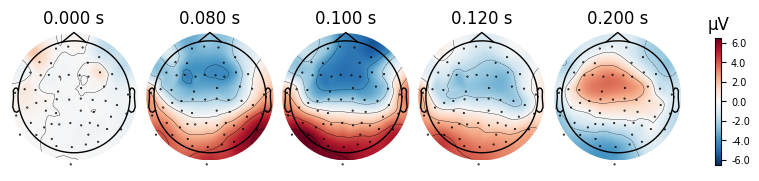

In [11]:
aud_evoked.plot_joint(picks="eeg")
aud_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

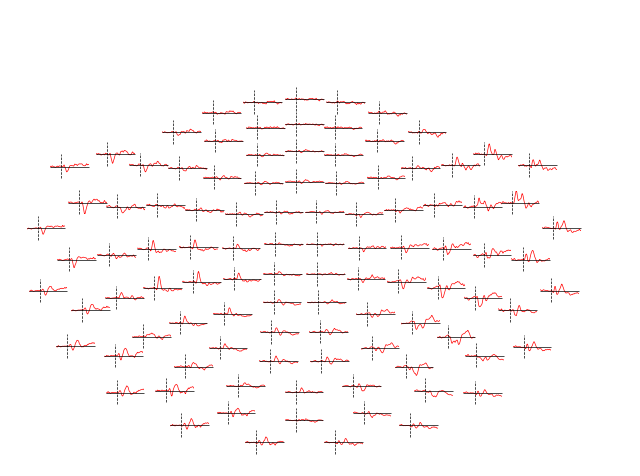

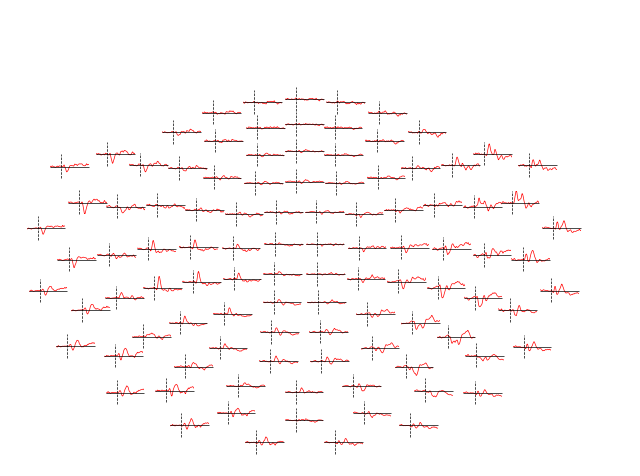

In [12]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick(picks="mag").plot_topo(color="r", legend=False)

In [13]:
def preprocess_eeg(sample_rate=100, tmin=-0.2, tmax=0.5):
    # Load example EEG from MNE sample dataset
    # sample_path = mne.datasets.sample.data_path()
    sample_data_folder = mne.datasets.sample.data_path()
    sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
    )
    raw = mne.io.read_raw_fif(sample_data_raw_file)
    orig_raw = raw.copy()
    raw.load_data()
    raw.filter(1., 40., fir_design='firwin')  # Bandpass 1-40Hz
    raw.resample(sample_rate)

    # Extract events
    events = mne.find_events(raw, stim_channel='STI 014')

    # Label mapping (e.g., pick auditory/visual left/right)
    event_id = {
        'auditory/left': 1,
        'auditory/right': 2,
        'visual/left': 3,
        'visual/right': 4
    }

    reject_criteria = dict(
        mag=4000e-15,  # 4000 fT
        grad=4000e-13,  # 4000 fT/cm
        eeg=150e-6,  # 150 µV
        eog=250e-6,
    )  # 250 µV

    # Epoch data into 1-second trials
    epochs = mne.Epochs(
        raw,
        events,
        event_id=event_id,
        tmin=-0.2,
        tmax=0.5,
        reject=reject_criteria,
        preload=True,
    )

    conds_we_care_about = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
    epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place

    # Extract numpy arrays
    X = epochs.get_data()  # shape: (n_samples, n_channels, n_times)
    y = epochs.events[:, -1] - 1  # remap to 0-based labels (0–3)
    
    return X, y

In [14]:
class EEGConvDataset(Dataset):
    def __init__(self, raw_data, labels):
        self.data = raw_data  # shape: (N, C, T)
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eeg_trial = self.data[idx]  # (n_channels, n_times)
        label = self.labels[idx]

        # Normalize
        eeg_trial = (eeg_trial - np.mean(eeg_trial)) / (np.std(eeg_trial) + 1e-8)

        # Reshape to (channels, height, width)
        x = torch.tensor(eeg_trial, dtype=torch.float32).unsqueeze(0)  # (1, C, T)
        y = torch.tensor(label, dtype=torch.long)
        return x, y  # x: [1, C, T] = [1, height, width]

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load experimental data
current_dir = os.getcwd()
experimental_data = load_SiOx_multistate("../data/SiO_x-multistate-data.mat")
(G_off, G_on, R, c, d_epsilon) = compute_PooleFrenkel_parameters(experimental_data)

# Preprocess EEG
X, y = preprocess_eeg()
split = int(0.8 * len(X))
train_ds = EEGConvDataset(X[:split], y[:split])
test_ds = EEGConvDataset(X[split:], y[split:])
batch_size=16

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

# Memristive parameters (use default/ideal for now)
# PF_config = {
#     "ideal": True,
#     "homeostasis_dropout": False,
# }
PF_config = {
    "ideal": False,
    "k_V": 0.5,
    "G_off": G_off,
    "G_on": G_on,
    "R": R,
    "c": c,
    "d_epsilon": d_epsilon,
    "disturb_conductance": True,
    "disturb_mode": "fixed",
    "disturbance_probability": 0.1,
    "homeostasis_dropout": True,
    "homeostasis_threshold": 5,
}

Opening raw data file C:\Users\User\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 497 samples (3.310 s)

Finding events on: STI 014
319 e

In [16]:
model = MCSNN(
    beta=0.95,
    spike_grad=surrogate.fast_sigmoid(slope=25),
    num_steps=10,
    batch_size=batch_size,
    num_kernels=4,
    num_conv1=8,
    num_conv2=16,
    max_pooling=2,
    num_outputs=4,
    input_shape=(1, 376, 71),
    memristive_config=PF_config
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
for epoch in range(100):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        spk, mem, _ = model(batch_x)
        loss = sum(loss_fn(mem[t], batch_y) for t in range(mem.size(0)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            spk_out, _, _ = model(batch_x)
            pred = spk_out.sum(dim=0).argmax(dim=1)
            correct += (pred == batch_y).sum().item()
            total += batch_y.size(0)

    print(f"Epoch {epoch+1}: Test Accuracy = {100. * correct / total:.2f}%")

Epoch 1: Test Accuracy = 22.92%
Epoch 2: Test Accuracy = 22.92%
Epoch 3: Test Accuracy = 33.33%
Epoch 4: Test Accuracy = 35.42%
Epoch 5: Test Accuracy = 45.83%
Epoch 6: Test Accuracy = 64.58%
Epoch 7: Test Accuracy = 66.67%
Epoch 8: Test Accuracy = 58.33%
Epoch 9: Test Accuracy = 70.83%
Epoch 10: Test Accuracy = 54.17%
Epoch 11: Test Accuracy = 64.58%
Epoch 12: Test Accuracy = 75.00%
Epoch 13: Test Accuracy = 72.92%
Epoch 14: Test Accuracy = 60.42%
Epoch 15: Test Accuracy = 85.42%
Epoch 16: Test Accuracy = 68.75%
Epoch 17: Test Accuracy = 83.33%
Epoch 18: Test Accuracy = 91.67%
Epoch 19: Test Accuracy = 83.33%
Epoch 20: Test Accuracy = 87.50%
Epoch 21: Test Accuracy = 81.25%
Epoch 22: Test Accuracy = 85.42%
Epoch 23: Test Accuracy = 81.25%
Epoch 24: Test Accuracy = 83.33%
Epoch 25: Test Accuracy = 100.00%
Epoch 26: Test Accuracy = 83.33%
Epoch 27: Test Accuracy = 97.92%
Epoch 28: Test Accuracy = 97.92%
Epoch 29: Test Accuracy = 89.58%
Epoch 30: Test Accuracy = 93.75%
Epoch 31: Test Acc

In [17]:
model.eval()
features = []
labels = []

with torch.no_grad():

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        _ , _, spk_int  = model(data)  
        
        spk_mean = spk_int.mean(dim=0)  # Average over time
        flattened = spk_mean.view(spk_mean.shape[0], -1)  # [B, features]
        
        features.append(flattened.cpu())
        labels.append(targets.cpu())
        
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        _ , _, spk_int  = model(data)  
        
        spk_mean = spk_int.mean(dim=0)  # Average over time
        flattened = spk_mean.view(spk_mean.shape[0], -1)  # [B, features]
        
        features.append(flattened.cpu())
        labels.append(targets.cpu())


        
features = torch.cat(features, dim=0)  # shape: [N, feature_dim]
labels = torch.cat(labels, dim=0)      # shape: [N]

features_np = features.numpy()
labels_np = labels.numpy()

# Normalize features
scaler = StandardScaler()
features_np = scaler.fit_transform(features_np)

id_to_label = {
    0: 'auditory/left',
    1: 'auditory/right',
    2: 'visual/left',
    3: 'visual/right'
}
label_names = np.array([id_to_label[l.item()] for l in labels_np])

# Convert tensors to NumPy arrays
features_np = features.numpy()
labels_np = labels.numpy()

# Replace numeric labels with string labels
label_names = np.array([id_to_label[l.item()] for l in labels_np])

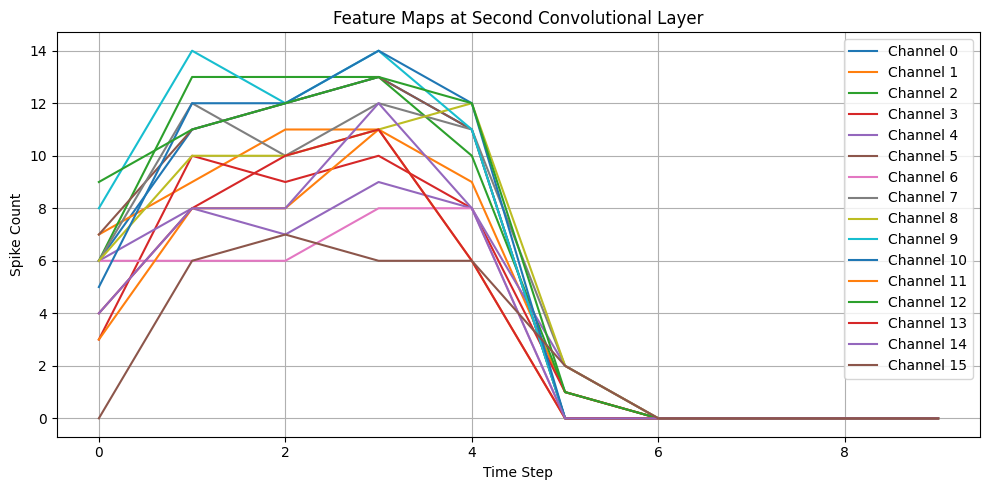

In [18]:
spk = spk_int[:, 5]  # [time, channels, h, w]
spike_rate = spk.view(spk.shape[0], spk.shape[1], -1).sum(-1)  # [time, channels]

plt.figure(figsize=(10, 5))
for ch in range(spike_rate.shape[1]):
    plt.plot(spike_rate[:, ch].cpu(), label=f'Channel {ch}')
plt.title(f"Feature Maps at Second Convolutional Layer")
plt.xlabel("Time Step")
plt.ylabel("Spike Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\User\anaconda3\envs\mnn_torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


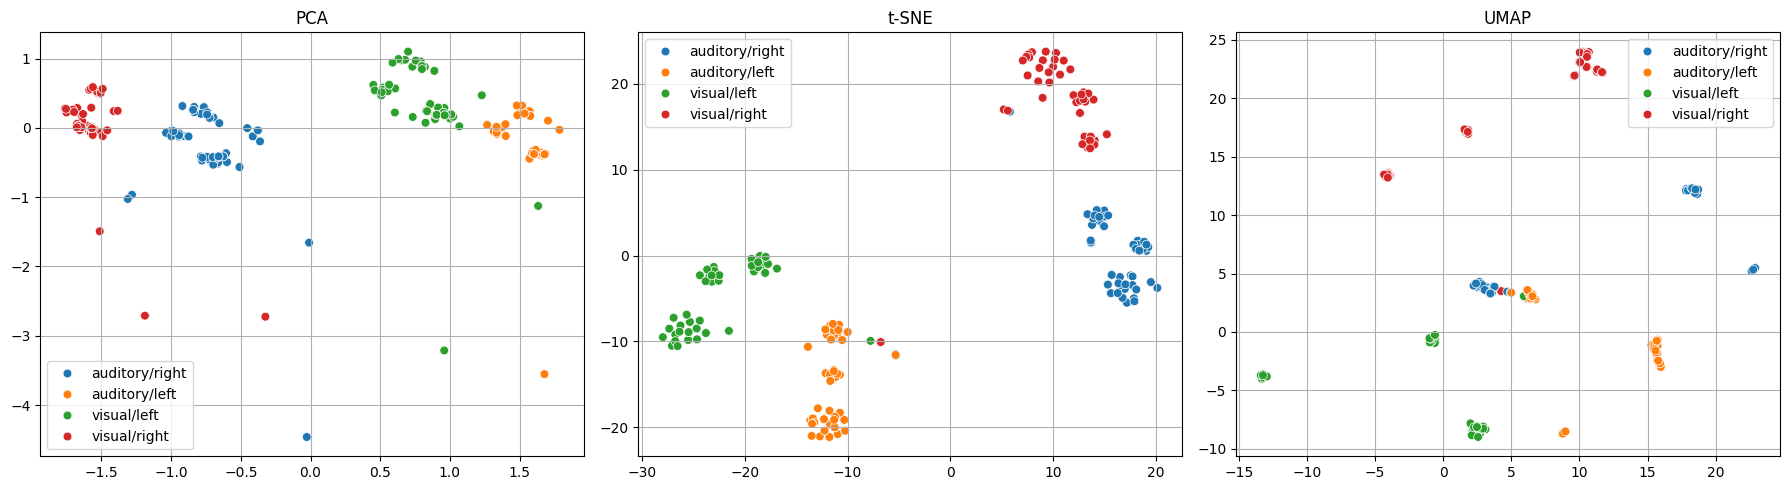

In [ ]:


pca = PCA(n_components=2)
pca_proj = pca.fit_transform(features.numpy())

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_proj = tsne.fit_transform(features.numpy())

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_proj = umap_model.fit_transform(features_np)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PCA
sns.scatterplot(x=pca_proj[:, 0], y=pca_proj[:, 1], hue=label_names,
                palette="tab10", ax=axes[0], legend='full', s=40)
axes[0].set_title("PCA")
axes[0].grid(True)

# t-SNE
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=label_names,
                palette="tab10", ax=axes[1], legend='full', s=40)
axes[1].set_title("t-SNE")
axes[1].grid(True)

# UMAP
sns.scatterplot(x=umap_proj[:, 0], y=umap_proj[:, 1], hue=label_names,
                palette="tab10", ax=axes[2], legend='full', s=40)
axes[2].set_title("UMAP")
axes[2].grid(True)

plt.tight_layout()
plt.show()

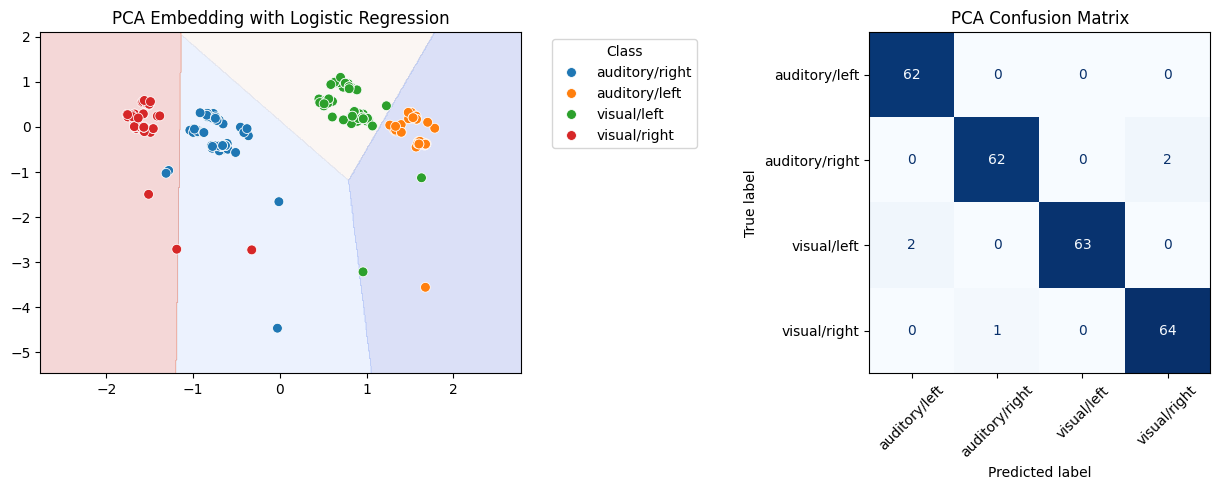

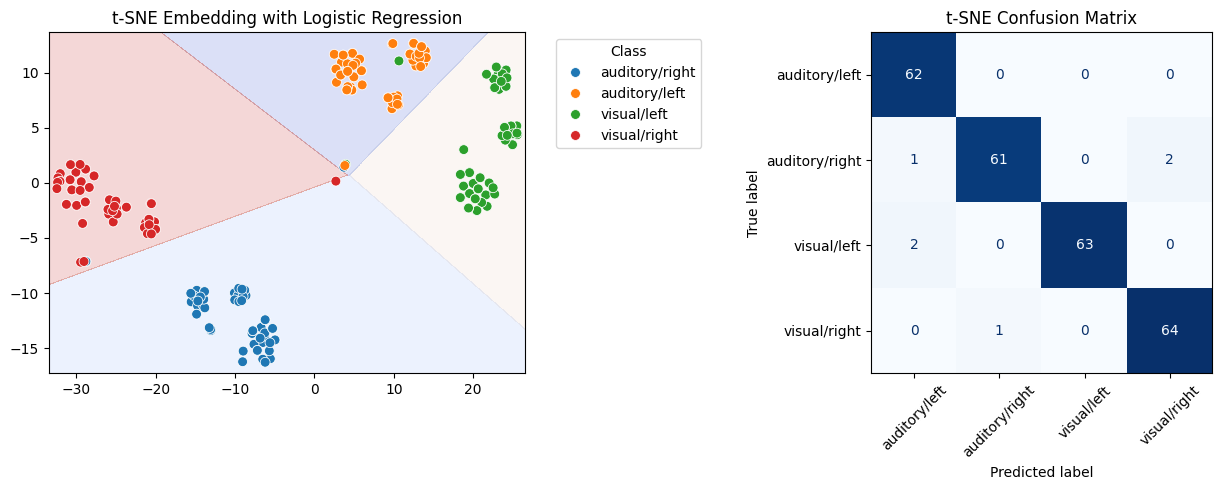

c:\Users\User\anaconda3\envs\mnn_torch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


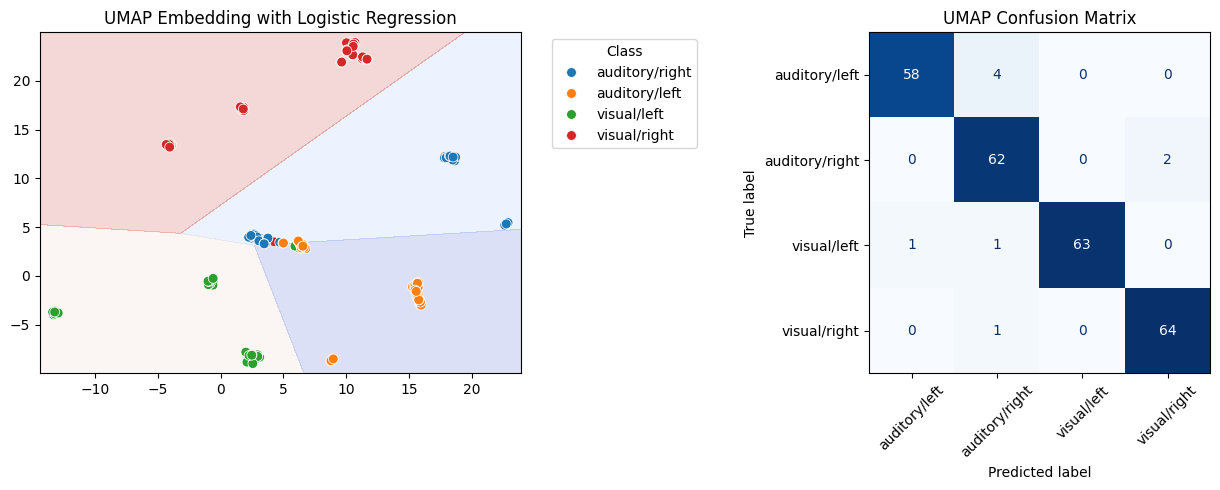

In [30]:
def embed_and_classify(features, labels, method="pca", name="PCA"):
    label_map = {
        0: 'auditory/left',
        1: 'auditory/right',
        2: 'visual/left',
        3: 'visual/right'
    }
    class_names = [label_map[i] for i in sorted(label_map.keys())]

    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Unknown method")

    embedded = reducer.fit_transform(features)
    labels_np = labels if isinstance(labels, np.ndarray) else labels.numpy()

    # Fit logistic regression on entire embedded space (as in the second code)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(embedded, labels_np)
    y_pred = clf.predict(embedded)

    # Decision boundary setup
    h = 0.01
    x_min, x_max = embedded[:, 0].min() - 1, embedded[:, 0].max() + 1
    y_min, y_max = embedded[:, 1].min() - 1, embedded[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Subplot layout
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))

    # Left: Embedding + Decision Boundary
    axs[0].contourf(xx, yy, Z, alpha=0.2, cmap="coolwarm")
    sns.scatterplot(
        x=embedded[:, 0],
        y=embedded[:, 1],
        hue=np.vectorize(label_map.get)(labels_np),
        palette="tab10",
        s=50,
        ax=axs[0]
    )
    axs[0].set_title(f"{name} Embedding with Logistic Regression")
    axs[0].legend(title="Class")

    # Right: Confusion Matrix
    cm = confusion_matrix(labels_np, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axs[1], cmap="Blues", colorbar=False, xticks_rotation=45)
    axs[1].set_title(f"{name} Confusion Matrix")

    plt.tight_layout()
    plt.show()

embed_and_classify(features_np, labels_np, method="pca", name="PCA")
embed_and_classify(features_np, labels_np, method="tsne", name="t-SNE")
embed_and_classify(features_np, labels_np, method="umap", name="UMAP")